In [ ]:
# Importación de bibliotecas necesarias para la manipulación de datos, modelado, visualización, y advertencias
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import os
import datetime as datetime
import warnings
warnings.filterwarnings("ignore")  # Ignorar advertencias para un entorno más limpio
import statsmodels.api as sm
from io import BytesIO
import re
import seaborn as sns
import io
import contextlib
import sys
from itertools import combinations
from tqdm import tqdm  # Utilizado para mostrar una barra de progreso en los loops largos
import statsmodels.api as sm
from pathlib import Path


# Obtener la ruta raíz del proyecto (2 niveles arriba del notebook)
ROOT_DIR = Path(os.getcwd()).parent.parent

# Definir rutas relativas a los directorios
DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = ROOT_DIR / 'output'

# Función para hacer que todas las series temporales mensuales sean estacionarias
def make_all_stationary_m(df):
    transformed_df = df.copy()  # Copiamos el DataFrame original para evitar modificarlo
    transformed_df = transformed_df.apply(np.log)  # Aplicamos logaritmo a todas las columnas para estabilizar la varianza
    
    diff_counts = {}  # Diccionario para almacenar el número de diferenciaciones por columna
    
    for column in transformed_df.columns:  # Iteramos sobre todas las columnas (series temporales)
        series = transformed_df[column]
        
        # Eliminamos valores faltantes
        series = series.dropna()
        
        p_value = 1  # Inicializamos el p-valor para comenzar la prueba
        diff_count = 0  # Contador para el número de diferenciaciones

        # Bucle que continúa hasta que la serie sea estacionaria (p-valor < 0.05)
        while p_value > 0.05:
            result = adfuller(series)  # Realiza el test ADF para verificar estacionariedad
            p_value = result[1]  # Obtiene el p-valor del test
            
            if p_value > 0.05:  # Si la serie no es estacionaria
                series = series.diff(3).dropna()  # Aplica una diferenciación de orden 3 y elimina valores NaN
                diff_count += 1  # Incrementa el contador de diferenciaciones
        
        transformed_df[column] = series  # Actualiza la columna transformada en el DataFrame
        diff_counts[column] = diff_count  # Guarda el número de diferenciaciones en el diccionario
    
    return transformed_df, diff_counts  # Retorna el DataFrame transformado y las diferenciaciones

# Función similar para series temporales trimestrales
def make_all_stationary_q(df):
    transformed_df = df.copy()  # Copiamos el DataFrame
    transformed_df = transformed_df.apply(np.log)  # Aplicamos logaritmo a todas las columnas
    
    diff_counts = {}  # Diccionario para almacenar el número de diferenciaciones por columna
    
    for column in transformed_df.columns:
        series = transformed_df[column]
        
        # Eliminamos valores faltantes
        series = series.dropna()
        
        p_value = 1  # Inicializa el p-valor para comenzar la prueba
        diff_count = 0  # Contador de diferenciaciones

        # Bucle que continúa hasta que la serie sea estacionaria (p-valor < 0.05)
        while p_value > 0.05:
            result = adfuller(series)  # Realiza el test ADF
            p_value = result[1]  # Obtiene el p-valor
            
            if p_value > 0.05:  # Si no es estacionaria
                series = series.diff().dropna()  # Diferenciación de orden 1
                diff_count += 1  # Incrementa el contador de diferenciaciones
        
        transformed_df[column] = series  # Actualiza la columna
        diff_counts[column] = diff_count  # Guarda el número de diferenciaciones
    
    return transformed_df, diff_counts  # Retorna el DataFrame y las diferenciaciones

# Creo dummies para intervenir COVID


# Patrón regex para extraer la fecha del nombre del archivo
patron_fecha = r'Envío_(\d{2})_(\d{2})_(\d{4})'

# Nombres de las hojas de cálculo de interés
nombre_hoja_mensual = 'Series_mens_vol_y_desest'
nombre_hoja_trimestre = 'Serie trim_vol_desest_Índice'

# Diccionarios para almacenar los DataFrames mensuales y trimestrales
dfs_m = {}
dfs_q = {}

# Ruta del archivo Excel que contiene los datos
ruta_archivo = DATA_DIR / "Envío_06_11_2024.xlsx"


# Obtener el nombre del archivo desde la ruta
archivo_nombre = os.path.basename(ruta_archivo)

# Extraer la fecha del nombre del archivo utilizando un split
fecha_str = archivo_nombre.split('_')[1] + archivo_nombre.split('_')[2] + archivo_nombre.split('_')[3].split('.')[0]

# Convertir la cadena en día, mes y año
dia = int(fecha_str[:2])
mes = int(fecha_str[2:4])
año = int(fecha_str[4:])

# Crear un objeto datetime con la fecha
fecha = datetime.datetime(año, mes, dia)

# Formatear la fecha en el formato deseado
fecha_formateada = fecha.strftime('%Y-%m-%d')

# Leer la hoja del Excel que contiene los datos mensuales
df_mens = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja_mensual)

# Convertir la columna 'fecha' al formato adecuado y establecerla como índice
df_mens['fecha'] = pd.to_datetime(df_mens['fecha']).dt.strftime('%m-%y')
df_mens.set_index('fecha', inplace=True)

# Aplicar una media móvil de 3 periodos y eliminar las primeras dos filas con valores NaN resultantes
df_mens = df_mens.rolling(window=3).mean()
df_mens = df_mens[2:]

# Leer la hoja del Excel que contiene los datos trimestrales
df_trims = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja_trimestre)
df_trims['fecha'] = pd.to_datetime(df_trims['fecha']).dt.strftime('%m-%y')
df_trims.set_index('fecha', inplace=True)

# Aplicar las funciones para hacer estacionarias las series mensuales y trimestrales
df_estacionario_mensual, diferencias_por_columna = make_all_stationary_m(df_mens)
df_estacionario_trimestral, diferencias_por_columna = make_all_stationary_q(df_trims)

# Aplicar diferenciación de orden 3 a ciertas columnas de interés
#df_estacionario_mensual['Pernoctaciones - Andalucía'] = df_estacionario_mensual['Pernoctaciones - Andalucía'].diff(3)
#df_estacionario_mensual['Total afiliados SS Total - Andalucía'] = df_mens['Total afiliados SS Total - Andalucía'].diff(3)

# Preparar las series como endógenas para el modelo
endog_m = df_estacionario_mensual
endog_q = df_estacionario_trimestral * 100  # Escalar por 100 las series trimestrales

# Convertir el índice a formato datetime y luego a periodos mensuales y trimestrales
endog_m.index = pd.to_datetime(endog_m.index, format='%m-%y').to_period('M')
endog_q.index = pd.to_datetime(endog_q.index, format='%m-%y').to_period('Q')

# Almacenar los DataFrames en los diccionarios con la fecha como clave
dfs_m[fecha] = endog_m
dfs_q[fecha] = endog_q

# Extraer los nombres de los regresores disponibles
regresores_disponibles_m = dfs_m[fecha].columns.tolist()
regresores_disponibles_q = dfs_q[fecha].columns.tolist()

# Copiar los datos para trabajar con ellos
endog_m_c = dfs_m[fecha].copy()
endog_q = dfs_q[fecha].copy()

# Lista combinada de regresores tanto mensuales como trimestrales
todos_regresores = regresores_disponibles_m + regresores_disponibles_q

# Variables para almacenar los resultados de la búsqueda de mejor modelo
resultados = []
max_r2_pib = -float('inf')  # Inicializamos el R² máximo como negativo infinito
mejor_modelo = None
mejor_comb_m = None
mejor_comb_q = None

# Calcular el total de combinaciones posibles de regresores
total_combinaciones = sum([len(list(combinations(todos_regresores, r))) for r in range(5, len(todos_regresores) + 1)])

# Crear dummies 2020 (antes de la función busqueda_eficiente)
endog_q['D2020Q1'] = 0
endog_q['D2020Q2'] = 0 
endog_q['D2020Q3'] = 0
endog_q['D2020Q4'] = 0

endog_q.loc['2020Q1', 'D2020Q1'] = 1
endog_q.loc['2020Q2', 'D2020Q2'] = 1
endog_q.loc['2020Q3', 'D2020Q3'] = 1 
endog_q.loc['2020Q4', 'D2020Q4'] = 1

# Función para evaluar un modelo dado un conjunto de regresores mensuales y trimestrales
def evaluar_modelo(endog_m, endog_q, comb_m, comb_q, num_factores, start_date, end_date):
    if not comb_m:
        return None, -np.inf, np.inf

    try:
        # Filtrar los datos para el rango de fechas especificado
        endog_m_filtered = endog_m.loc[start_date:end_date]
        endog_q_filtered = endog_q.loc[start_date:end_date]

        num_factores = min(len(comb_m), num_factores)
        
        comb_q = comb_q + ['D2020Q1', 'D2020Q2', 'D2020Q3', 'D2020Q4']


        mod = sm.tsa.DynamicFactorMQ(
            endog_m_filtered[comb_m], 
            endog_quarterly=endog_q_filtered[comb_q], 
            factor_orders=1,
            factors=num_factores,
            factor_multiplicities=None
        )
        res = mod.fit(maxiter=2000)
        
        rsquared = res.get_coefficients_of_determination(method='individual')
        r2_pib = rsquared.loc['pib'].max()
        
        pib_predicho = res.predict()['pib']
        variabilidad = np.sum(np.abs(np.diff(pib_predicho)))
        pib_ultimos = pib_predicho['2021Q3':end_date].resample('Q').first().shift(-1).dropna()
        pib_ultimos_orig = endog_q_filtered.loc['2021Q3':end_date]['pib']
        
        pib_ultimos_orig = pib_ultimos_orig[pib_ultimos.index]
        
        # Calcular R² 
        modelo1 = sm.OLS(pib_ultimos_orig, sm.add_constant(pib_ultimos)).fit()
        r2_reciente = modelo1.rsquared.round(4)

        return res, r2_pib, variabilidad, r2_reciente
    except Exception as e:
        print(f"Error al estimar el modelo: {e}")
        return None, -np.inf, np.inf, -np.inf

# Función para calcular una métrica combinada que balancea R² y la variabilidad
def calcular_metrica_combinada(r2, variabilidad, r2_reciente, peso_r2, peso_variabilidad, peso_r2_reciente):
    r2_normalizado = (r2 + 1) / 2  # Normalizamos el R² al rango [0, 1]
    r2_reciente_normalizado = (r2_reciente + 1) / 2
    variabilidad_normalizada = 1 / (1 + variabilidad)  # Invertimos y normalizamos la variabilidad
    return peso_r2 * r2_normalizado + peso_variabilidad * variabilidad_normalizada + peso_r2_reciente*r2_reciente_normalizado  # Calculamos la métrica

# Función de búsqueda eficiente del mejor modelo con paciencia para mejorar resultados
def busqueda_eficiente(endog_m, endog_q, todos_regresores, start_date, end_date, max_vars=10, paciencia=5, 
                       peso_r2=0.4, peso_variabilidad=0.3, peso_r2_reciente=0.3, factores=[1, 2, 3]):
    regresores_disponibles_m = [var for var in todos_regresores if var in endog_m.columns]
    regresores_disponibles_q = [var for var in todos_regresores if var in endog_q.columns]
    
    if 'pib' in regresores_disponibles_q:
        regresores_disponibles_q.remove('pib')
    
    mejor_modelo = None
    mejor_metrica = -np.inf
    mejor_r2 = -np.inf
    mejor_variabilidad = np.inf
    mejor_r2_reciente = -np.inf 
    mejor_comb_m = []
    mejor_comb_q = ['pib']
    mejor_num_factores = 1
    sin_mejora = 0
    
    if regresores_disponibles_m:
        mejor_comb_m = [regresores_disponibles_m[0]]
        regresores_disponibles_m = regresores_disponibles_m[1:]
    
    with tqdm(total=max_vars, desc="Buscando mejor modelo") as pbar:
        while len(mejor_comb_m) + len(mejor_comb_q) < max_vars and sin_mejora < paciencia:
            mejor_nueva_var = None
            mejor_nueva_metrica = mejor_metrica
            mejor_nuevo_r2 = mejor_r2
            mejor_nueva_variabilidad = mejor_variabilidad
            mejor_nuevo_num_factores = mejor_num_factores
            
            for num_factores in factores:
                for var in regresores_disponibles_m:
                    if var not in mejor_comb_m:
                        nueva_comb_m = mejor_comb_m + [var]
                        modelo, r2, variabilidad, r2_final = evaluar_modelo(endog_m, endog_q, nueva_comb_m, mejor_comb_q, num_factores, start_date, end_date)
                        metrica = calcular_metrica_combinada(r2, variabilidad, r2_final, peso_r2, peso_variabilidad, peso_r2_reciente)
                        if metrica > mejor_nueva_metrica:
                            mejor_nueva_metrica = metrica
                            mejor_nuevo_r2 = r2
                            mejor_nueva_variabilidad = variabilidad
                            mejor_nuevo_r2_reciente = r2_final  # Actualizar aquí también
                            mejor_nueva_var = ('m', var)
                            mejor_nuevo_num_factores = num_factores
                
                for var in regresores_disponibles_q:
                    if var not in mejor_comb_q:
                        nueva_comb_q = mejor_comb_q + [var]
                        modelo, r2, variabilidad, r2_final = evaluar_modelo(endog_m, endog_q, mejor_comb_m, nueva_comb_q, num_factores, start_date, end_date)
                        metrica = calcular_metrica_combinada(r2, variabilidad, r2_final, peso_r2, peso_variabilidad, peso_r2_reciente)
                        if metrica > mejor_nueva_metrica:
                            mejor_nueva_metrica = metrica
                            mejor_nuevo_r2 = r2
                            mejor_nueva_variabilidad = variabilidad
                            mejor_nuevo_r2_reciente = r2_final  # Actualizar aquí también
                            mejor_nueva_var = ('q', var)
                            mejor_nuevo_num_factores = num_factores
                
            if mejor_nueva_var:
                if mejor_nueva_var[0] == 'm':
                    mejor_comb_m.append(mejor_nueva_var[1])
                    regresores_disponibles_m.remove(mejor_nueva_var[1])
                else:
                    mejor_comb_q.append(mejor_nueva_var[1])
                    regresores_disponibles_q.remove(mejor_nueva_var[1])
                
                if mejor_nueva_metrica > mejor_metrica:
                    mejor_metrica = mejor_nueva_metrica
                    mejor_r2 = mejor_nuevo_r2
                    mejor_r2_reciente = mejor_nuevo_r2_reciente
                    mejor_variabilidad = mejor_nueva_variabilidad
                    mejor_num_factores = mejor_nuevo_num_factores
                    mejor_modelo, _, _, _ = evaluar_modelo(endog_m, endog_q, mejor_comb_m, mejor_comb_q, mejor_num_factores, start_date, end_date)
                    sin_mejora = 0
                    print(f"Nueva mejor métrica: {mejor_metrica:.3f}, R²: {mejor_r2:.3f}, R² reciente: {mejor_r2_reciente:.3f},  "
                          f"Variabilidad: {mejor_variabilidad:.3f}, Variables mensuales: {len(mejor_comb_m)}, "
                          f"Variables trimestrales: {len(mejor_comb_q)}, Factores: {mejor_num_factores}")
                else:
                    sin_mejora += 1
            else:
                break
            
            pbar.update(1)
    
        return mejor_modelo, mejor_comb_m, mejor_comb_q, mejor_r2, mejor_variabilidad, mejor_r2_reciente, mejor_num_factores

# Uso de la función de búsqueda eficiente con el rango de fechas especificado
start_date = '2002Q1'
end_date = '2024Q3'
peso_r2=0.8
peso_variabilidad=0.1
peso_r2_reciente=0.1
paciencia=5
max_vars=10

# Asegúrate de que los índices de endog_m y endog_q sean PeriodIndex
endog_m.index = pd.PeriodIndex(endog_m.index, freq='M')
endog_q.index = pd.PeriodIndex(endog_q.index, freq='Q')

# Uso de la función de búsqueda eficiente para encontrar el mejor modelo
mejor_modelo, mejor_comb_m, mejor_comb_q, max_r2_pib, min_variabilidad, max_r2_pib_reciente, mejor_num_factores = busqueda_eficiente(
    endog_m, endog_q, todos_regresores, start_date, end_date, max_vars, paciencia, factores=[1, 2, 3],
    peso_r2=0.8, peso_variabilidad=0.1, peso_r2_reciente=0.1
    )


# Imprimir los resultados del mejor modelo encontrado
print("\nMejor modelo encontrado:")
print(f"Combinación Mensual: {mejor_comb_m}")
print(f"Combinación Trimestral: {mejor_comb_q}")
print(f"Número de factores: {mejor_num_factores}")
print(f"R^2 máximo PIB: {max_r2_pib:.3f}")
print(f"Variabilidad mínima: {min_variabilidad:.3f}")
print(f"R^2 máximo PIB reciente: {max_r2_pib_reciente:.3f}")

if mejor_modelo:
    print(mejor_modelo.summary())  # Si se encuentra un modelo, imprimimos su resumen
else:
    print("No se pudo encontrar un modelo válido.")  # En caso de fallo

Buscando mejor modelo:   0%|          | 0/10 [00:00<?, ?it/s]

Error al estimar el modelo: Singular matrix


Buscando mejor modelo:  10%|█         | 1/10 [02:17<20:37, 137.49s/it]

Nueva mejor métrica: 0.825, R²: 0.836, R² reciente: 0.791,  Variabilidad: 174.021, Variables mensuales: 2, Variables trimestrales: 1, Factores: 1


Buscando mejor modelo:  20%|██        | 2/10 [07:20<31:19, 234.88s/it]

Nueva mejor métrica: 0.860, R²: 0.919, R² reciente: 0.840,  Variabilidad: 163.191, Variables mensuales: 3, Variables trimestrales: 1, Factores: 1


Buscando mejor modelo:  30%|███       | 3/10 [09:54<23:04, 197.85s/it]

Nueva mejor métrica: 0.861, R²: 0.919, R² reciente: 0.846,  Variabilidad: 162.336, Variables mensuales: 3, Variables trimestrales: 2, Factores: 1
Error al estimar el modelo: array must not contain infs or NaNs


Buscando mejor modelo:  40%|████      | 4/10 [15:23<24:57, 249.53s/it]

Nueva mejor métrica: 0.861, R²: 0.924, R² reciente: 0.828,  Variabilidad: 171.715, Variables mensuales: 4, Variables trimestrales: 2, Factores: 1


Buscando mejor modelo:  50%|█████     | 5/10 [22:08<25:28, 305.76s/it]

Nueva mejor métrica: 0.862, R²: 0.924, R² reciente: 0.832,  Variabilidad: 171.703, Variables mensuales: 5, Variables trimestrales: 2, Factores: 1


Buscando mejor modelo:  50%|█████     | 5/10 [26:13<26:13, 314.64s/it]


Mejor modelo encontrado:
Combinación Mensual: ['Consumo aparente de cemento - Andalucía', 'Cifra negocios del sector servicios - Andalucía', 'ICMA General sin estaciones de servicios', 'Índice general de producción industrial - Andalucía', 'Liquidación de presupuestos de la Junta de Andalucía. Capítulo 1 - Andalucía']
Combinación Trimestral: ['pib', 'Índice de producción agrícola - Andalucía']
Número de factores: 1
R^2 máximo PIB: 0.924
Variabilidad mínima: 171.703
R^2 máximo PIB reciente: 0.832
                                        Dynamic Factor Results                                        
Dep. Variable:     "Consumo aparente de ceme...", and 10 more   No. Observations:                  273
Model:                                   Dynamic Factor Model   Log Likelihood               -1860.528
                                      + 1 factors in 1 blocks   AIC                           3791.056
                                      + Mixed frequency (M/Q)   BIC                   

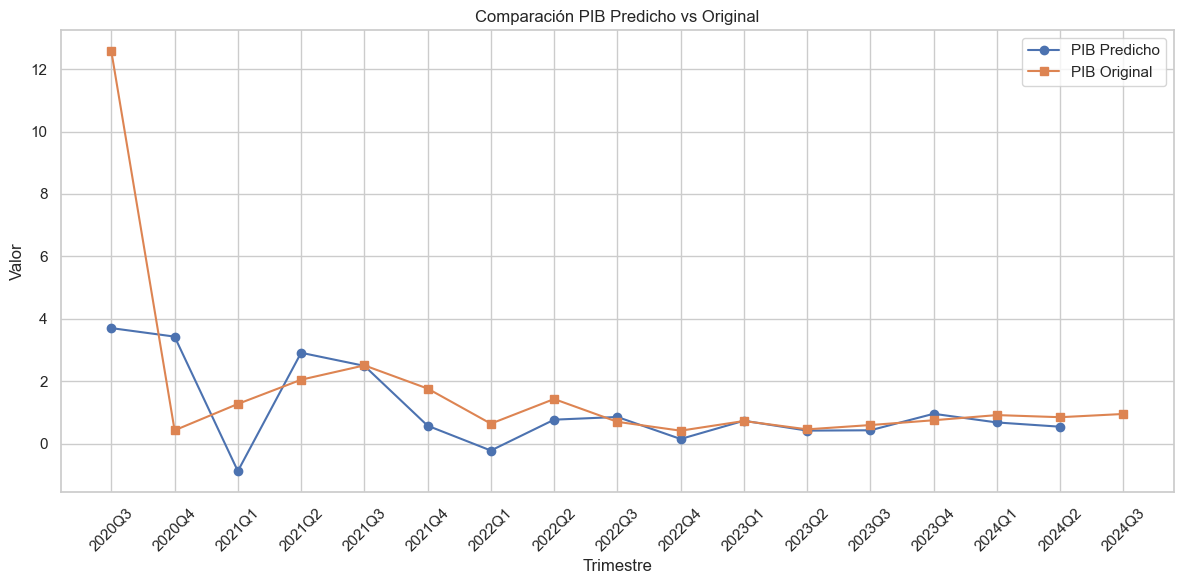

In [43]:
# Obtener las predicciones del mejor modelo
pib_predicho = mejor_modelo.predict()['pib']

# Obtener los últimos valores desde 2021Q3
pib_ultimos = pib_predicho['2020Q3':end_date].resample('Q').last().shift(-1).dropna()
pib_ultimos_orig = endog_q.loc['2020Q3':end_date]['pib']

# Crear la visualización
plt.figure(figsize=(12, 6))
plt.plot(pib_ultimos.index.astype(str), pib_ultimos, 
         label='PIB Predicho', marker='o')
plt.plot(pib_ultimos_orig.index.astype(str), pib_ultimos_orig, 
         label='PIB Original', marker='s')

plt.title('Comparación PIB Predicho vs Original')
plt.xlabel('Trimestre')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


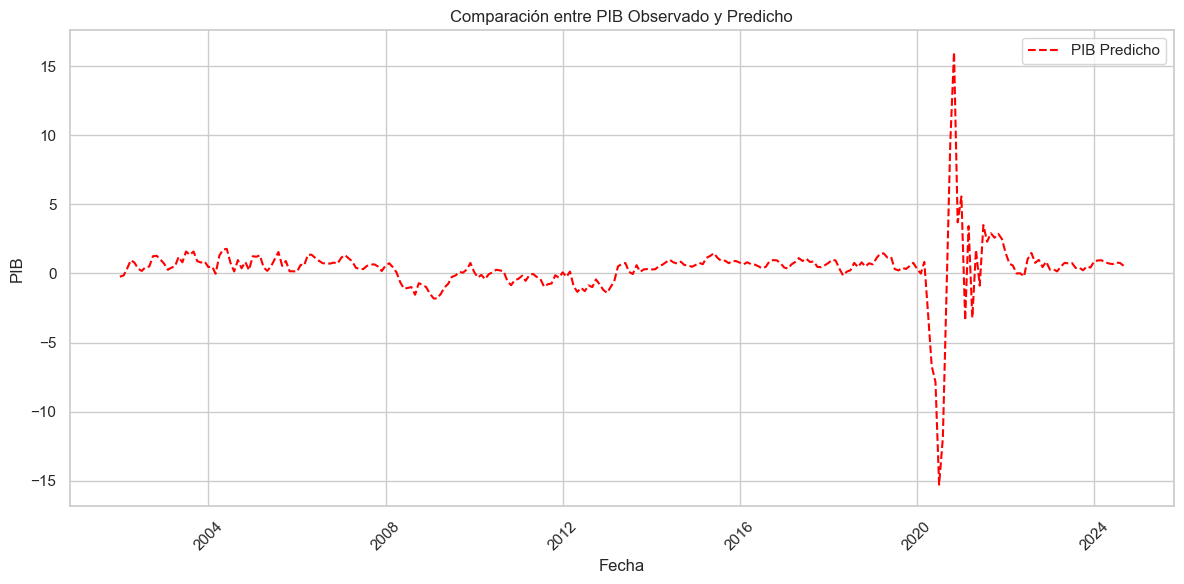

In [40]:
# Convertir el índice de Period a Timestamp si es necesario
predicciones = mejor_modelo.predict()
predicciones.index = predicciones.index.to_timestamp()

# Obtener predicciones del modelo
pib_predicho = predicciones['pib']

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(predicciones.index, pib_predicho, label='PIB Predicho', color='red', linestyle='--')

plt.title('Comparación entre PIB Observado y Predicho')
plt.xlabel('Fecha')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()



ValueError: x and y must have same first dimension, but have shapes (99,) and (19,)

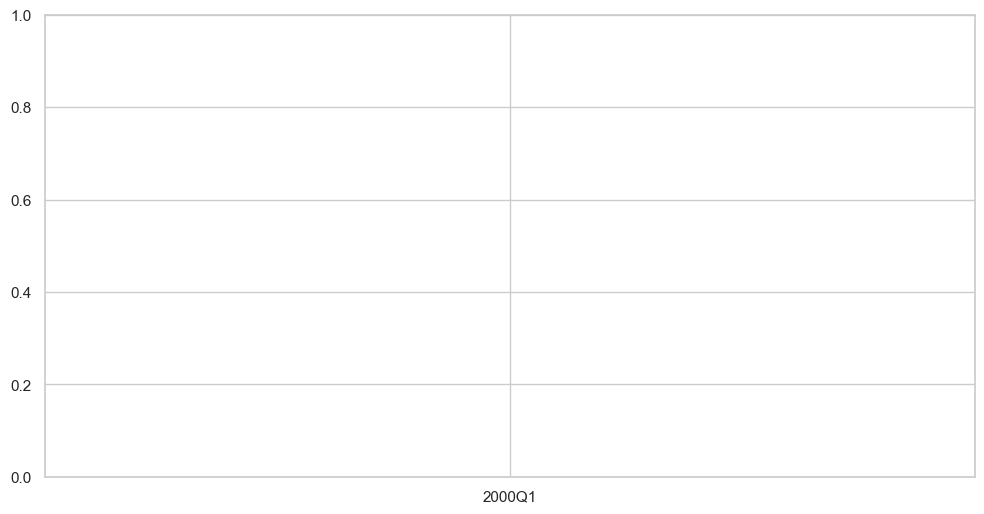

In [41]:
# Paso 1: Resamplear pib_predicho a frecuencia trimestral (media de cada trimestre)
pib_predicho_trimestral = pib_predicho.resample('Q').mean().shift(-1)

# Paso 2: Convertir el índice a period[Q-DEC] para que coincida con endog_q
pib_predicho_trimestral.index = pib_predicho_trimestral.index.to_period('Q-DEC')

# Paso 3: Crear el DataFrame combinando las dos series
df_combinado = pd.DataFrame({
    'pib_predicho': pib_predicho_trimestral,
    'pib_endogeno': endog_q['pib']
})

# Aquí se debe incluir la creación de df_combinado como se mencionó anteriormente.

# Configurar el estilo de seaborn
sns.set(style='whitegrid')

# Crear el gráfico
plt.figure(figsize=(12, 6))  # Tamaño de la figura

# Graficar la serie pib_predicho
plt.plot(df_combinado.index.astype(str), df_combinado['pib_predicho']['2020Q1':], label='PIB Predicho', color='blue', marker='o')

# Graficar la serie pib_endogeno
plt.plot(df_combinado.index.astype(str), df_combinado['pib_endogeno']['2020Q1':], label='PIB Endógeno', color='orange', marker='o')

# Añadir título y etiquetas
plt.title('Comparación del PIB Predicho y PIB Endógeno', fontsize=16)
plt.xlabel('Fecha (Trimestral)', fontsize=14)
plt.ylabel('Valor del PIB', fontsize=14)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.legend()  # Añadir leyenda
plt.tight_layout()  # Ajustar el layout

# Mostrar el gráfico
plt.show()


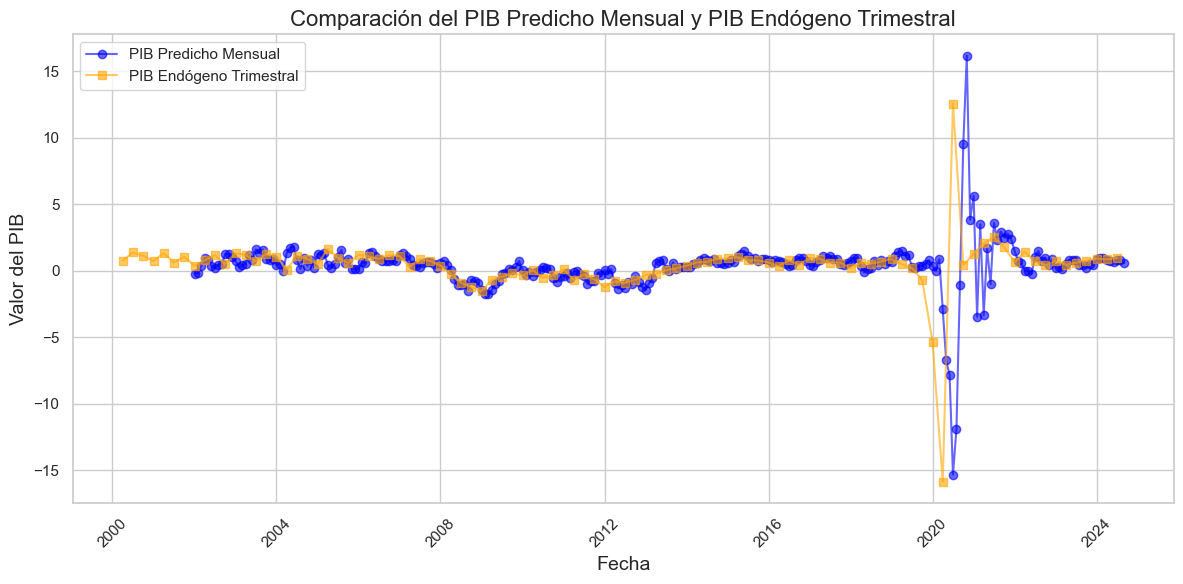

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que ya tienes tus series: pib_predicho (mensual) y endog_q['pib'] (trimestral)

# Configurar el estilo de seaborn
sns.set(style='whitegrid')

# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar la serie mensual (pib_predicho)
plt.plot(pib_predicho.index, pib_predicho, label='PIB Predicho Mensual', color='blue', marker='o', alpha=0.6)

# Graficar la serie trimestral (pib_endogeno)
plt.plot(endog_q.index.to_timestamp(), endog_q['pib'], label='PIB Endógeno Trimestral', color='orange', marker='s', alpha=0.6)

# Añadir título y etiquetas
plt.title('Comparación del PIB Predicho Mensual y PIB Endógeno Trimestral', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Valor del PIB', fontsize=14)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.legend()  # Añadir leyenda
plt.tight_layout()  # Ajustar el layout

# Mostrar el gráfico
plt.show()


In [24]:
pib_predicho.to_excel(r'C:\Users\Usuario\Downloads\pib_predicho.xlsx')  # Guardar las predicciones en un archivo Excel

In [6]:
import numpy as np
from scipy import stats

def chow_lin_method(y, X, high_freq=12, low_freq=4):
    """
    Implementa el método de Chow-Lin para la desagregación temporal de series.
    
    Parámetros:
    y (array): Serie de baja frecuencia (ej. trimestral)
    X (array): Matriz de indicadores de alta frecuencia (ej. mensual)
    high_freq (int): Número de períodos de alta frecuencia por año (default=12 para mensual)
    low_freq (int): Número de períodos de baja frecuencia por año (default=4 para trimestral)
    
    Retorna:
    array: Serie desagregada de alta frecuencia
    """
    
    # Aseguramos que y sea un vector columna
    y = y.reshape(-1, 1)
    
    # Aseguramos que X sea una matriz 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    # Calculamos la frecuencia de desagregación
    frequency = high_freq // low_freq
    
    # Agregamos los indicadores de alta frecuencia a baja frecuencia
    X_low_freq = X.reshape(-1, frequency, X.shape[1]).sum(axis=1)
    
    # Estimamos los coeficientes de regresión
    beta = np.linalg.lstsq(X_low_freq, y, rcond=None)[0]
    
    # Calculamos los residuos de baja frecuencia
    residuals = y - X_low_freq @ beta
    
    # Estimamos el parámetro autorregresivo de los residuos
    if len(np.unique(residuals)) > 1:
        rho = np.clip(stats.pearsonr(residuals[:-1].flatten(), residuals[1:].flatten())[0], -0.999, 0.999)
    else:
        rho = 0  # Si los residuos son constantes, asumimos no autocorrelación
    
    # Construimos la matriz de covarianza de los errores
    T = len(y) * frequency
    V = np.zeros((T, T))
    for i in range(T):
        for j in range(T):
            V[i, j] = rho ** abs(i - j)
    
    # Construimos la matriz de agregación
    C = np.kron(np.eye(len(y)), np.ones((frequency, 1)))
    
    # Calculamos la matriz de transformación
    Q = V - V @ C @ np.linalg.inv(C.T @ V @ C) @ C.T @ V
    
    # Calculamos las estimaciones de alta frecuencia
    y_high_freq = X @ beta + Q @ C @ np.linalg.inv(C.T @ Q @ C) @ residuals
    
    return y_high_freq.flatten()

# Ejemplo de uso para mensualizar datos trimestrales
if __name__ == "__main__":
    # Datos de ejemplo (4 trimestres)
    y_trimestral = np.array([300, 320, 310, 350])
    
    # Indicador mensual (12 meses)
    X_mensual = np.array([85, 110, 105, 100, 120, 110, 105, 110, 100, 115, 125, 115])
    
    # Aplicamos el método de Chow-Lin para mensualizar
    y_mensual = chow_lin_method(y_trimestral, X_mensual, high_freq=12, low_freq=4)
    
    print("Serie trimestral:", y_trimestral)
    print("Serie mensualizada:", y_mensual)
    print("Suma de meses por trimestre:", y_mensual.reshape(-1, 3).sum(axis=1))

Serie trimestral: [300 320 310 350]
Serie mensualizada: [ 85.47112907 107.70054838 106.82832255  95.41394591 120.94372214
 103.64233195 104.12503787 113.17813365  92.69682847 112.14969636
 123.72708936 114.12321428]
Suma de meses por trimestre: [300. 320. 310. 350.]
